#유럽축구리그 홈팀 승률에 코로나19가 끼친 영향분석 Bassed on Permutation Test

# Google Drive 연결하기

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


#0.	데이터의 정의와 전처리

In [2]:
import pandas as pd
df=pd.read_csv('/content/gdrive/MyDrive/19_20_uefa_big_5.csv', encoding = 'euc-kr')
df.head(5)

,날짜,리그,팀,상대,득점,실점,승리,장소,시기
0,2019-08-10,EPL,크리스탈 팰리스,에버턴,0,0,0,안방,BC
1,2019-08-10,EPL,왓포드 FC,브라이튼,0,3,0,안방,BC
2,2019-08-10,EPL,웨스트햄,맨시티,0,5,0,안방,BC
3,2019-08-10,EPL,AFC 본머스,셰필드,1,1,0,안방,BC
4,2019-08-10,EPL,번리,사우샘프턴,3,0,1,안방,BC


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3450 entries, 0 to 3449
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   날짜      3450 non-null   object
 1   리그      3450 non-null   object
 2   팀       3450 non-null   object
 3   상대      3450 non-null   object
 4   득점      3450 non-null   int64 
 5   실점      3450 non-null   int64 
 6   승리      3450 non-null   int64 
 7   장소      3450 non-null   object
 8   시기      3450 non-null   object
dtypes: int64(3), object(6)
memory usage: 242.7+ KB


In [4]:
df1 = df.groupby(['팀', '장소'], as_index = False)\
  .agg(승리 = ('승리','mean'))

df1

,팀,장소,승리
0,AC 밀란,방문,0.526316
1,AC 밀란,안방,0.473684
2,AFC 본머스,방문,0.210526
3,AFC 본머스,안방,0.263158
4,AS 로마,방문,0.578947
...,...,...,...
191,헤르타 BSC,안방,0.352941
192,헤타페,방문,0.315789
193,헤타페,안방,0.421053
194,호펜하임,방문,0.470588


#1.	홈경기와 원정경기 사이의 승률 차이의 유의성을 살펴본다.

##1.1 Box-plot과 기술통계량을 통해 홈과 원정 승률 차이를 확인한다

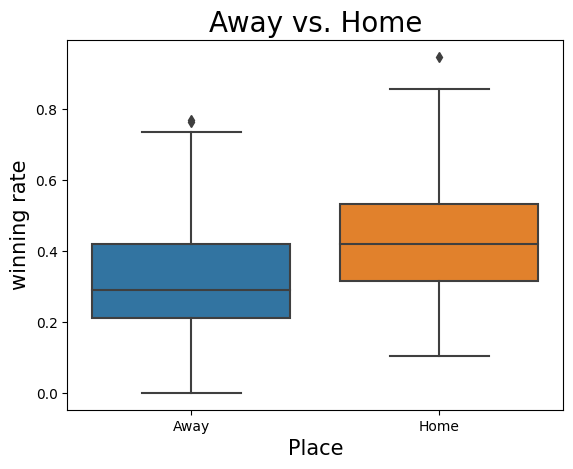

In [5]:
#PKG
import matplotlib.pyplot as plt
import seaborn as sns

# Boxplot
sns.boxplot(x = '장소', y = '승리',data = df1)
plt.title('Away vs. Home', fontsize=20)
plt.xlabel('Place', fontsize=15)
plt.ylabel('winning rate', fontsize=15)
plt.xticks([0, 1], ['Away', 'Home'])
plt.show()

In [6]:
df1.groupby('장소', as_index = False).agg(mean = ('승리', 'mean'))

,장소,mean
0,방문,0.314397
1,안방,0.441927


##1.2 T-Test를 통해 유의성 가설검정을 확인한다

In [7]:
away = df1[df1['장소'] == '방문']['승리']
home = df1[df1['장소'] == '안방']['승리']

from scipy import stats
stat_value, p_value = stats.ttest_ind(home, away, 
                                      equal_var = True, 
                                      alternative = 'greater')
print('P-Value :', p_value)

P-Value : 5.268108096916975e-07


##1.3 Permutation test를 우연성 통계적 가설검정

###1.3.1 데이터 뒤섞기(랜덤화)

In [8]:
# PKG
import random
import numpy as np

# 1~196 데이터 모두 랜덤으로 추출하기
sample_data = random.sample(range(1,197), 196)
result = np.array(sample_data) % 2

df1['랜덤_장소']= np.where(result == 0, '안방','방문')

###1.3.2 Box-plot & 기술통계량

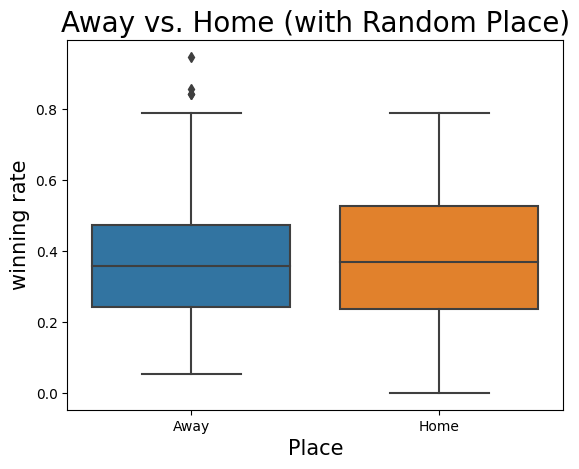

In [9]:
# Boxplot
sns.boxplot(x = '랜덤_장소', y = '승리',data = df1)
plt.title('Away vs. Home (with Random Place)', fontsize=20)
plt.xlabel('Place', fontsize=15)
plt.ylabel('winning rate', fontsize=15)
plt.xticks([0, 1], ['Away', 'Home'])
plt.show()

In [10]:
df1.groupby('랜덤_장소', as_index = False).agg(mean = ('승리', 'mean'))

,랜덤_장소,mean
0,방문,0.374482
1,안방,0.381842


###1.3.3 순열검정(Permutation test)

#### [알고리즘]

In [11]:
import numpy as np

# Define two groups of data
away = df1[df1['장소'] == '방문']['승리']
home = df1[df1['장소'] == '안방']['승리']

# Calculate the observed test statistic
observed_statistic = np.mean(home) - np.mean(away)

# Combine the two groups
combined = np.concatenate([home, away])

# Number of permutations
num_permutations = 1000

# Initialize an array to store permuted test statistics
permuted_statistics = np.zeros(num_permutations)

# Permutation test
for i in range(num_permutations):
    # Randomly permute the combined data
    permuted_data = np.random.permutation(combined)

    # Split the permuted data into two groups
    permuted_home = permuted_data[:len(home)]
    permuted_away = permuted_data[len(home):]

    # Calculate the test statistic for the permuted data
    permuted_statistic = np.mean(permuted_home) - np.mean(permuted_away)

    # Store the permuted test statistic
    permuted_statistics[i] = permuted_statistic


#### [P-값]

In [12]:
# Calculate the p-value
p_value = (np.abs(permuted_statistics) >= np.abs(observed_statistic)).mean()

print("Observed test statistic:", observed_statistic)
print("P-value:", p_value)

Observed test statistic: 0.1275298552040829
P-value: 0.0


In [13]:
print('P-Value : ',(permuted_statistics > 0.128).mean())
print()
print("P-vlaue가 0.05보다 작기 때문에 귀무가설을 기각한다.")

P-Value :  0.0

P-vlaue가 0.05보다 작기 때문에 귀무가설을 기각한다.


#### [히스토그램]

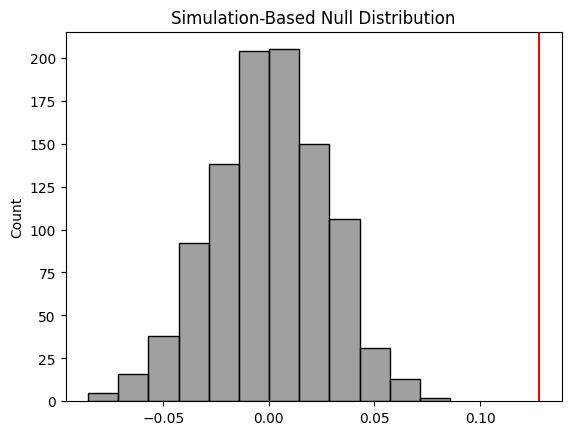

In [14]:
import seaborn as sns
sns.histplot(data = permuted_statistics, bins = 12, color='gray')
plt.axvline(x = 0.128, color='r')
plt.title('Simulation-Based Null Distribution')
plt.show()

In [15]:
intercept_5 = round(np.percentile(permuted_statistics, 95),3)
print(intercept_5)

0.041


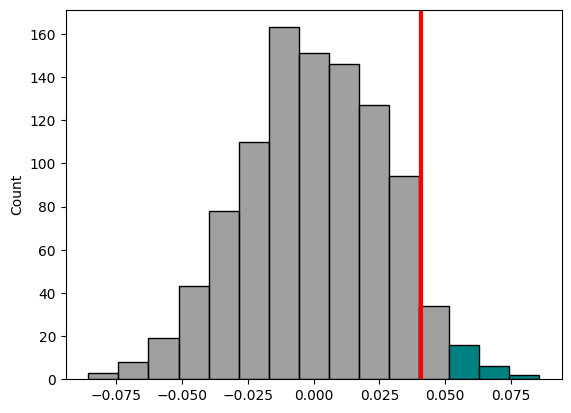

In [16]:
import seaborn as sns
from matplotlib.patches import Rectangle

p=sns.histplot(permuted_statistics, color='gray', bins = 15)
plt.axvline(round(intercept_5, 3), color = 'red', linewidth = 3)

for rectangle in p.patches:
    if rectangle.get_x() >= round(intercept_5, 3) :
        rectangle.set_facecolor('teal')

Rectangle(xy=(round(intercept_5, 3), 0), width=1.28523-round(intercept_5, 3), 
          height=180, angle=0).set_facecolor('teal')

#2. 코로나 전후의 Home 승률의 차이 확인

In [17]:
df2 = df[(df['장소'] == '안방') & (df['리그'] != '리그1')].groupby(['팀','시기'], as_index = False)
df2 = df2[['승리']].agg(승리 = ('승리', 'mean'))
df2

,팀,시기,승리
0,AC 밀란,AC,0.666667
1,AC 밀란,BC,0.384615
2,AFC 본머스,AC,0.200000
3,AFC 본머스,BC,0.285714
4,AS 로마,AC,0.666667
...,...,...,...
151,헤르타 BSC,BC,0.230769
152,헤타페,AC,0.200000
153,헤타페,BC,0.500000
154,호펜하임,AC,0.500000


In [18]:
df2.groupby('시기', as_index = False).agg(mean = ('승리', 'mean'))

,시기,mean
0,AC,0.421337
1,BC,0.438894


##2.1 Box-plot과 기술통계량을 통해 홈과 원정 승률 차이를 확인한다

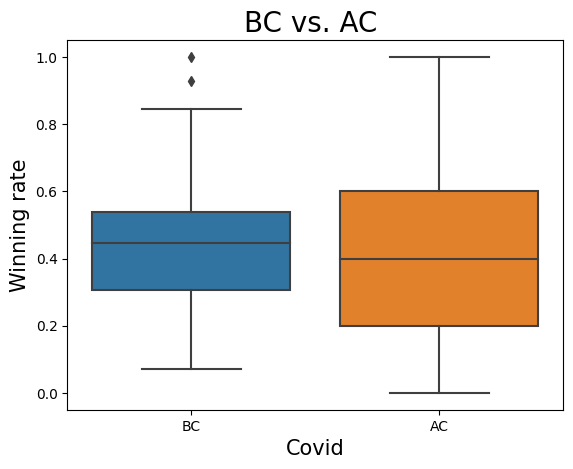

In [19]:
# Boxplot
sns.boxplot(x = '시기', y = '승리',order = ['BC', 'AC'],data = df2)
plt.title('BC vs. AC ', fontsize=20)
plt.xlabel('Covid', fontsize=15)
plt.ylabel('Winning rate', fontsize=15)
plt.show()

##2.2 T-Test를 통해 유의성 가설검정을 확인한다

In [20]:
# data
AC = df2[df2['시기'] == 'AC']['승리']
BC = df2[df2['시기'] == 'BC']['승리']

# PKG
from scipy import stats
stat_value, p_value = stats.ttest_ind(AC, BC, 
                                      alternative = 'less')
print('P-Value :', round(p_value,3))

P-Value : 0.321


##2.3 Permutation test를 우연성 통계적 가설검정

###2.3.1 데이터 뒤섞기(랜덤화)

In [21]:
# PKG
import random
import numpy as np

# 1~156 데이터 모두 랜덤으로 추출하기
sample_data = random.sample(range(1,157), 156)
result = np.array(sample_data) % 2

df2['랜덤_시기']= np.where(result == 0, 'BC','AC')

###2.3.2 Box-plot & 기술통계량

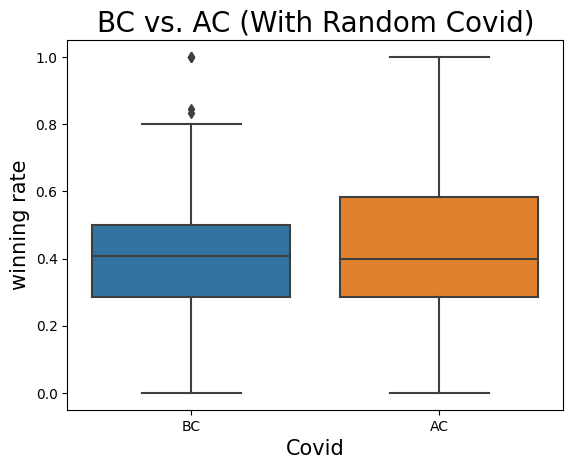

In [22]:
# Boxplot
sns.boxplot(x = '랜덤_시기', y = '승리',data = df2)
plt.title('BC vs. AC (With Random Covid)', fontsize=20)
plt.xlabel('Covid', fontsize=15)
plt.ylabel('winning rate', fontsize=15)
plt.xticks([0, 1], ['BC', 'AC'])
plt.show()

In [23]:
df2.groupby('랜덤_시기', as_index = False).agg(mean = ('승리', 'mean'))

,랜덤_시기,mean
0,AC,0.425130
1,BC,0.435101


###2.3.3 순열검정(Permutation test)

#### [알고리즘]

In [24]:
import numpy as np

# Define two groups of data
AC = df2[df2['시기'] == 'AC']['승리']
BC = df2[df2['시기'] == 'BC']['승리']

# Calculate the observed test statistic
observed_statistic = np.mean(AC) - np.mean(BC)

# Combine the two groups
combined = np.concatenate([AC,BC])

# Number of permutations
num_permutations = 1000

# Initialize an array to store permuted test statistics
permuted_statistics = np.zeros(num_permutations)

# Permutation test
for i in range(num_permutations):
    # Randomly permute the combined data
    permuted_data = np.random.permutation(combined)

    # Split the permuted data into two groups
    permuted_AC = permuted_data[:len(AC)]
    permuted_BC = permuted_data[len(AC):]

    # Calculate the test statistic for the permuted data
    permuted_statistic = np.mean(permuted_AC) - np.mean(permuted_BC)

    # Store the permuted test statistic
    permuted_statistics[i] = permuted_statistic


#### [히스토그램]

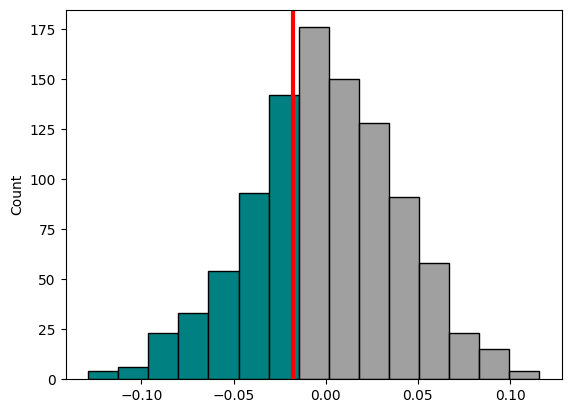

In [25]:
import seaborn as sns
from matplotlib.patches import Rectangle

p=sns.histplot(permuted_statistics, color='gray', bins = 15)
plt.axvline(round(observed_statistic, 3), color = 'r', linewidth = 3)

for rectangle in p.patches:
    if rectangle.get_x() <= round(observed_statistic, 3) :
        rectangle.set_facecolor('teal')

Rectangle(xy=(round(observed_statistic, 3), 0), 
          width=1.28523-round(observed_statistic, 3), 
          height=180, angle=0).set_facecolor('teal')


#### [P-값]

In [26]:
p_value = round((permuted_statistics < -0.018).mean(),3)
print(p_value)

0.33
